# Reactor Kinetics Example 

Jialu Wang (jwang44@nd.edu) and Alex Dowling (adowling@nd.edu)

University of Notre Dame

This notebook conducts design of experiments for a reactor kinetics experiment with the Pyomo.DoE.
    

## Step 0: Import Pyomo and Pyomo.DoE module

In [1]:
import numpy as np
import pyomo.environ as pyo
from pyomo.contrib.doe import DesignOfExperiments, MeasurementVariables, DesignVariables

In [2]:
## check if ipopt available 
ipopt_available = pyo.SolverFactory('ipopt').available()
if not (ipopt_available):
    raise RuntimeError('This Pyomo.DoE example requires Ipopt.')

## Step 1: Import Reaction Example Mathematical Model

Consider two chemical reactions that convert molecule $A$ to desired product $B$ and a less valuable side-product $C$.

$A \overset{k_1}{\rightarrow} B \overset{k_2}{\rightarrow} C$

Our ultimate goal is to design a large-scale continuous reactor that maximizes the production of $B$. This general sequential reactions problem is widely applicable to CO$_2$ capture and industry more broadly (petrochemicals, pharmaceuticals, etc.).

The rate laws for these two chemical reactions are:

$r_A = -k_1 C_A$

$r_B = k_1 C_A - k_2 C_B$

$r_C = k_2 C_B$

Here, $C_A$, $C_B$, and $C_C$ are the concentrations of each species. The rate constants $k_1$ and $k_2$ depend on temperature as follows:

$k_1 = A_1 \exp{\frac{-E_1}{R T}}$

$k_2 = A_2 \exp{\frac{-E_2}{R T}}$

$A_1, A_2, E_1$, and $E_2$ are fitted model parameters. $R$ is the ideal-gas constant and $T$ is absolute temperature.

Using the **CCSI$^2$ toolset**, we would like to perform **uncertainty quantification** and **design of experiments** on a small-scale **batch reactor** to infer parameters $A_1$, $A_2$, $E_1$, and $E_2$.

### Batch reactor

The concentrations in a batch reactor evolve with time per the following differential equations:

$$ \frac{d C_A}{dt} = r_A = -k_1 C_A $$

$$ \frac{d C_B}{dt} = r_B = k_1 C_A - k_2 C_B $$

$$ \frac{d C_C}{dt} = r_C = k_2 C_B $$

This is a linear system of differential equations. Assuming the feed is only species $A$, i.e., 

$$C_A(t=0) = C_{A0} \quad C_B(t=0) = 0 \quad C_C(t=0) = 0$$

When the temperature is constant, it leads to the following analytic solution:

$$C_A(t) = C_{A,0} \exp(-k_1 t)$$

$$C_B(t) = \frac{k_1}{k_2 - k_1} C_{A,0} \left[\exp(-k_1 t) - \exp(-k_2 t) \right]$$

$$C_C(t) = C_{A,0} - \frac{k_2}{k_2 - k_1} C_{A,0} \exp(-k_1 t) + \frac{k_1}{k_2 - k_1} \exp(-k_2 t) C_{A,0} = C_{A,0} - C_{A}(t) - C_{B}(t)$$

In [3]:
from pyomo.contrib.doe.example.reactor_kinetics import create_model, disc_for_measure

## Step 2: Define inputs

In [4]:
# Control time set [h]
t_control = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1] 
# Define parameter nominal value 
parameter_dict = {'A1': 84.79, 'A2': 371.72, 'E1': 7.78, 'E2': 15.05}

In [5]:
### Pyomo.DoE define measurements. Measurements have at most 1 index besides the time index
variable_name = "C"
indices = {0:['CA', 'CB', 'CC'], 1: t_control}

measure_class = MeasurementVariables()
measure_class.add_variables(variable_name, indices=indices, time_index_position = 1)
print("measurement names:", measure_class.variable_names)

measurement names: ['C[CA,0]', 'C[CA,0.125]', 'C[CA,0.25]', 'C[CA,0.375]', 'C[CA,0.5]', 'C[CA,0.625]', 'C[CA,0.75]', 'C[CA,0.875]', 'C[CA,1]', 'C[CB,0]', 'C[CB,0.125]', 'C[CB,0.25]', 'C[CB,0.375]', 'C[CB,0.5]', 'C[CB,0.625]', 'C[CB,0.75]', 'C[CB,0.875]', 'C[CB,1]', 'C[CC,0]', 'C[CC,0.125]', 'C[CC,0.25]', 'C[CC,0.375]', 'C[CC,0.5]', 'C[CC,0.625]', 'C[CC,0.75]', 'C[CC,0.875]', 'C[CC,1]']


In [6]:
design_gen = DesignVariables()

var_C = 'CA0'
indices_C = {0:[0]}
exp1_C = [5]

# add design variable
design_gen.add_variables(var_C, indices = indices_C, time_index_position=0,
                         values=exp1_C,lower_bounds=1, upper_bounds=5)
                        

var_T = 'T'
indices_T = {0:t_control}
exp1_T = [470, 300, 300, 300, 300, 300, 300, 300, 300]

design_gen.add_variables(var_T, indices = indices_T, time_index_position=0,
                         values=exp1_T,lower_bounds=300, upper_bounds=700)
print("Design variable names:", design_gen.variable_names)

Design variable names: ['CA0[0]', 'T[0]', 'T[0.125]', 'T[0.25]', 'T[0.375]', 'T[0.5]', 'T[0.625]', 'T[0.75]', 'T[0.875]', 'T[1]']


In [7]:
param_dict = {'A1': 84.79, 'A2': 371.72, 'E1': 7.78, 'E2': 15.05}


## Method: Compute FIM 

This method computes an MBDoE optimization problem with no degrees of freedom.

In [8]:
# choose from 'sequential_finite', 'direct_kaug'
#sensi_opt = "direct_kaug"
sensi_opt = "sequential_finite"

# Define experiments
design_names = design_gen.variable_names
exp1 = [5, 470, 300, 300, 300, 300, 300, 300, 300, 300]
exp1_design_dict = dict(zip(design_names, exp1))

design_gen.update_values(exp1_design_dict)

In [9]:
doe_object = DesignOfExperiments(parameter_dict, design_gen,
                                 measure_class, create_model,
                                 discretize_model=disc_for_measure)


result = doe_object.compute_FIM(mode=sensi_opt, FIM_store_name = 'dynamic.csv', 
                                read_output=None,
                                scale_nominal_param_value=True,
                                formula = "central")


result.result_analysis()


Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

In [10]:
print('======Result summary======')
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(result.trace))
print('D-optimality:', np.log10(result.det))
print('E-optimality:', np.log10(result.min_eig))
print('Modified E-optimality:', np.log10(result.cond))
print(result.FIM)

======Result summary======
Four design criteria log10() value:
A-optimality: 2.9897244624254227
D-optimality: 3.3010989022799095
E-optimality: -0.9193349136173019
Modified E-optimality: 3.8768075549543988
[[  17.22096879   13.67125453  -37.1471375   -68.68858407]
 [  13.67125453   34.5737961   -26.37449298 -170.10871631]
 [ -37.1471375   -26.37449298   81.32448107  133.30724227]
 [ -68.68858407 -170.10871631  133.30724227  843.49816474]]


In [11]:
### choose a subset of measurements, get results without resolving the model
sub_name = "C"
sub_indices = {0: ["CB", "CC"], 1:[0.125, 0.25, 0.5, 0.75, 0.875] }

measure_subset = MeasurementVariables()
measure_subset.add_variables(sub_name, indices = sub_indices, time_index_position=1)
print(measure_subset.variable_names)

['C[CB,0.125]', 'C[CB,0.25]', 'C[CB,0.5]', 'C[CB,0.75]', 'C[CB,0.875]', 'C[CC,0.125]', 'C[CC,0.25]', 'C[CC,0.5]', 'C[CC,0.75]', 'C[CC,0.875]']


In [12]:
sub_result = result.subset(measure_subset)
sub_result.result_analysis()
print('======Subset Result summary======')
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(sub_result.trace))
print('D-optimality:', np.log10(sub_result.det))
print('E-optimality:', np.log10(sub_result.min_eig))
print('Modified E-optimality:', np.log10(sub_result.cond))

======Subset Result summary======
Four design criteria log10() value:
A-optimality: 2.7312606650205957
D-optimality: 1.82134503385468
E-optimality: -1.430816119608334
Modified E-optimality: 4.147090377572721


## Method: Optimization
Gradient-based optimization with IPOPT with stochastic_program()

This function solves twice: It solves the square version of the MBDoE problem first, and then unfixes the design variables as degrees of freedom and solves again. In this way the optimization problem can be well initialized. 

In [13]:
exp1 = [5, 500, 300, 300, 300, 300, 300, 300, 300, 300]
exp1_design_dict = dict(zip(design_names, exp1))
design_gen.update_values(exp1_design_dict)

# add a prior information (scaled FIM with T=500 and T=300 experiments)
prior = np.asarray([[  28.67892806 ,   5.41249739 , -81.73674601 , -24.02377324],
 [   5.41249739 ,  26.40935036 , -12.41816477 , -139.23992532],
 [ -81.73674601 , -12.41816477 , 240.46276004 ,  58.76422806],
 [ -24.02377324 , -139.23992532 ,  58.76422806 , 767.25584508]])



In [14]:
doe_object = DesignOfExperiments(parameter_dict, design_gen,
                                 measure_class, create_model,
                                 prior_FIM=prior, discretize_model=disc_for_measure)

square_result, optimize_result= doe_object.stochastic_program(if_optimize=True, if_Cholesky=True, 
                                                            scale_nominal_param_value=True, objective_option="det", 
                                                            L_initial=np.linalg.cholesky(prior))

Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

In [15]:
print('======Result summary======')
print('This optimization is solved with status:', optimize_result.status)
print('C solution:', pyo.value(optimize_result.model.CA0[0]))
print("T solution:")
for t in t_control:
    print(pyo.value(optimize_result.model.T[t]))

print('The result FIM is: \n', optimize_result.FIM)
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(optimize_result.trace))
print('D-optimality:', np.log10(optimize_result.det))
print('E-optimality:', np.log10(optimize_result.min_eig))
print('Modified E-optimality:', np.log10(optimize_result.cond))


======Result summary======
This optimization is solved with status: converged
C solution: 5.0
T solution:
579.3896783399584
300.0000882599865
300.00014490662824
300.00020111344645
300.00026910716207
300.000375033031
300.0005830403824
300.0011944366598
300.00407697618726
The result FIM is: 
 [[  46.26165476   24.02303687 -111.13766256  -98.84248626]
 [  24.02303687   56.00005104  -41.78107761 -257.31551924]
 [-111.13766256  -41.78107761  290.39184704  177.30569626]
 [ -98.84248626 -257.31551924  177.30569626 1245.59268666]]
Four design criteria log10() value:
A-optimality: 3.2143791797303467
D-optimality: 6.214368093239911
E-optimality: 0.007877626244739868
Modified E-optimality: 3.1198074131079294


## Method: Exploratory analysis (Enumeration)

This method conducts exploratory analysis by enumeration. 
It allows a user to define any number (dimensions) of design variables.
Heatmaps can be drawn by two design variables, fixing other design variables; 
1D curve can be drawn by one design variable, fixing other design variables.

### Specify user inputs

In [16]:
# Design variable ranges as lists 
design_ranges = {'CA0[0]': [1,3,5], 
                 ('T[0]', 'T[0.125]','T[0.25]','T[0.375]',
                  'T[0.5]','T[0.625]','T[0.75]','T[0.875]','T[1]'): [300,500,700]}

## choose from 'sequential_finite', 'direct_kaug'
#sensi_opt = "sequential_finite"
sensi_opt = "direct_kaug"

In [19]:
# add prior information
prior_pass = [[ 22.52943024 , 1.84034314, -70.23273336, -11.09432962],
 [   1.84034314 ,  18.09848116 ,  -5.73565034 , -109.15866135],
 [ -70.23273336 ,  -5.73565034 , 218.94192843 ,  34.57680848],
 [ -11.09432962 , -109.15866135 ,  34.57680848 ,  658.37644634]]

print('The prior information FIM:\n', prior_pass)
print('Prior Det:', np.linalg.det(prior_pass))

The prior information FIM:
 [[22.52943024, 1.84034314, -70.23273336, -11.09432962], [1.84034314, 18.09848116, -5.73565034, -109.15866135], [-70.23273336, -5.73565034, 218.94192843, 34.57680848], [-11.09432962, -109.15866135, 34.57680848, 658.37644634]]
Prior Det: 1.9558434466145787e-08


In [20]:
doe_object = DesignOfExperiments(parameter_dict, design_gen,
                                 measure_class, create_model,
                                prior_FIM=prior_pass, discretize_model=disc_for_measure)

all_fim = doe_object.run_grid_search(design_ranges, 
                                     mode=sensi_opt)

### 1D sensitivity curve

   CA0[0]  \
0     1.0   
1     1.0   
2     1.0   
3     3.0   
4     3.0   
5     3.0   
6     5.0   
7     5.0   
8     5.0   

   (T[0], T[0.125], T[0.25], T[0.375], T[0.5], T[0.625], T[0.75], T[0.875], T[1])  \
0                                              300.0                                
1                                              500.0                                
2                                              700.0                                
3                                              300.0                                
4                                              500.0                                
5                                              700.0                                
6                                              300.0                                
7                                              500.0                                
8                                              700.0                                

            A     

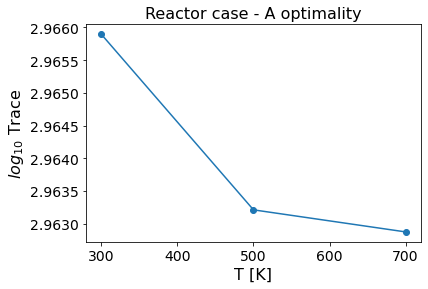

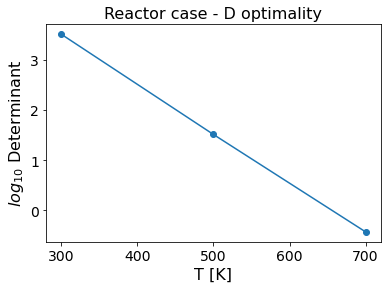

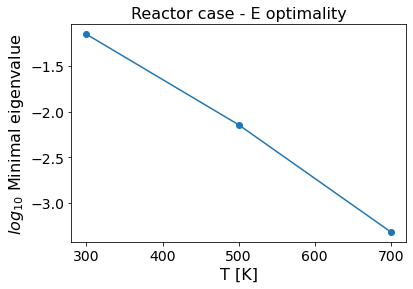

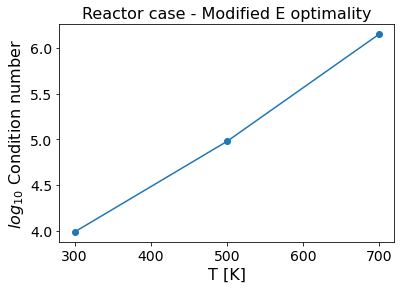

In [21]:
all_fim.extract_criteria()
print(all_fim.store_all_results_dataframe)
## draw 1D sensitivity curve 
# this problem has two degrees of freedom, to draw 1D curve it needs to fix one dimension
fixed = {"'CA0[0]'": 5.0}

all_fim.figure_drawing(fixed, [('T[0]', 'T[0.125]','T[0.25]','T[0.375]',
                  'T[0.5]','T[0.625]','T[0.75]','T[0.875]','T[1]')], 'Reactor case','T [K]','$C_{A0}$ [M]' )



## Heatmap

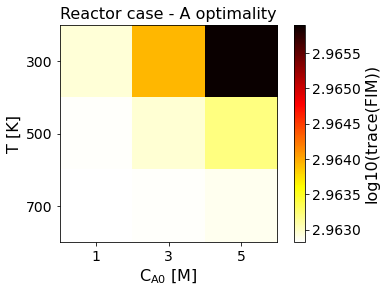

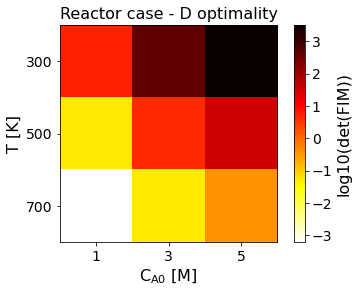

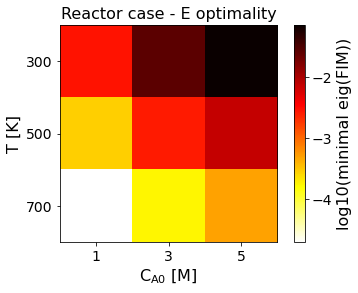

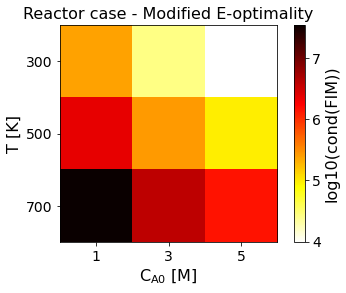

In [22]:
# this problem has two degrees of freedom, to draw heatmap it does not need to fix any dimension

fixed = {}
all_fim.figure_drawing(fixed, ['CA0[0]','T[0]'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )

### Read Heatmaps

A heatmap shows the change of the objective function, a.k.a. the experimental information content, in the design region. Horizontal and vertical axes are two design variables, while the color of each grid shows the experimental information content. Taking the Fig. Reactor case - A optimality as example, A-optimality shows that the most informative region is around $C_{A0}=5.0$ M, $T=300.0$ K, while the least informative region is around $C_{A0}=1.0$ M, $T=700.0$ K.

## Grid search for 3 design variables

In [23]:
# Define design ranges
design_ranges ={'CA0[0]': list(np.linspace(1,5,2)),  
                'T[0]': list(np.linspace(300,700,2)), 
                ('T[0.125]','T[0.25]','T[0.375]','T[0.5]','T[0.625]','T[0.75]','T[0.875]','T[1]'): [300,500]}

## choose from 'sequential_finite', 'direct_kaug'
sensi_opt = "direct_kaug"

In [24]:
doe_object = DesignOfExperiments(parameter_dict, design_gen,
                                 measure_class, create_model,
                                prior_FIM=prior_pass, discretize_model=disc_for_measure)

all_fim = doe_object.run_grid_search(design_ranges, 
                                     mode=sensi_opt)

### Draw 1D sensitivity curve

In [25]:
test = all_fim.extract_criteria()

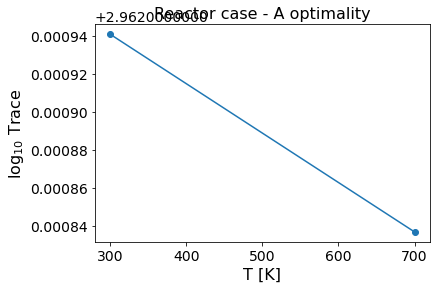

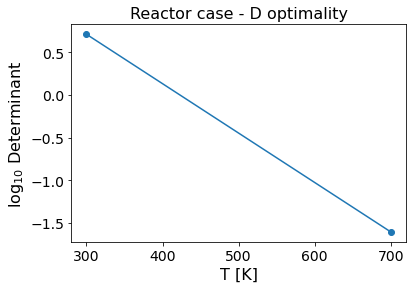

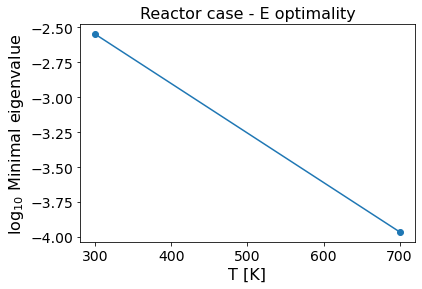

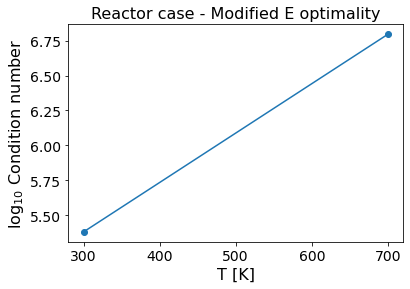

In [26]:
## draw 1D sensitivity curve 
# this problem has three degrees of freedom, to draw 1D curve it needs to fix two dimensions
fixed = {"'CA0[0]'": 1.0, "('T[0.125]','T[0.25]','T[0.375]','T[0.5]','T[0.625]','T[0.75]','T[0.875]','T[1]')": 300}

all_fim.figure_drawing(fixed, ['T[0]'], 'Reactor case','T [K]','$C_{A0}$ [M]' )

### Draw 2D sensitivity curve

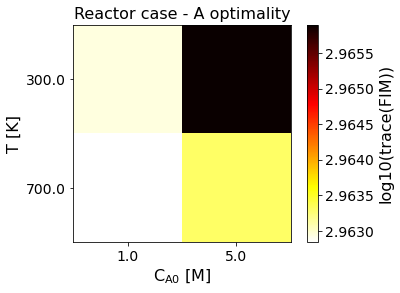

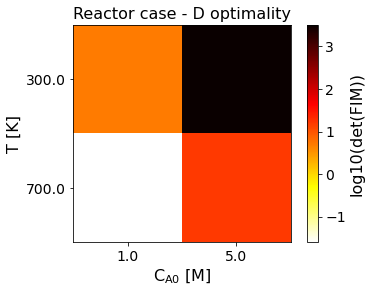

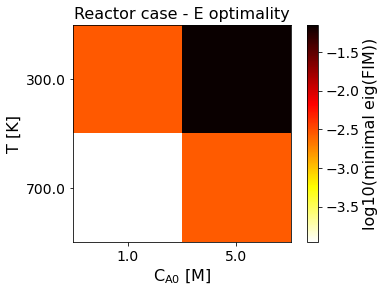

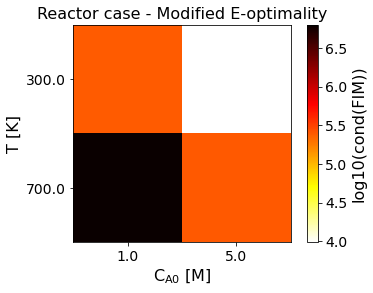

In [27]:
# this problem has three degrees of freedom, to draw heatmap it needs to fix one dimension
fixed = {"('T[0.125]','T[0.25]','T[0.375]','T[0.5]','T[0.625]','T[0.75]','T[0.875]','T[1]')": 300}

all_fim.figure_drawing(fixed, ['CA0[0]','T[0]'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )